In [1]:
import json
import utils
import time
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

import impmeas as imp

def test_method(model_key, model, method_key, method, n, m, k, formula_strings):
    for formula in tqdm(formula_strings, desc=f"{model_key} + {method_key}"):
        start = time.time()
        f = model.parse(formula)
        end1 = time.time()
        method(f)
        end2 = time.time()
        methodtime, overalltime = end2-end1, end2-start
        yield methodtime*1000, overalltime*1000

# approx hard instances for clauses / n = 3
# (see e.g. https://www.cs.cornell.edu/selman/papers/pdf/96.aij.generating.pdf)
dataset = pd.read_csv("dataset.csv", index_col=0) if os.path.exists("dataset.csv") else pd.DataFrame()
k, clause_to_variables = 3, 3 
for n in range(28, 53, 3):
    m = int(n*clause_to_variables) 
    print(f"generating formulas for n={n}")
    formula_strings = [ imp.formulas.formula2tree(imp.random_k_cnf(n,m,k)[1]) for _ in range(5) ]

    print(f"testing BDD/GPMC on n={n} m={m} k={k}")
    vars = [f"x{idx+1}" for idx in range(n)]
    imp.formulas.set_pmc_solver(imp.formulas.GPMC(bj=True, cs=6000))
    imp.formulas.set_buddy_context(vars, nodenum=1<<27, cachesize=1<<20)

    methods = { 
        "blame": lambda f: imp.blame(f, "x1"),
        "mod_blame": lambda f: imp.blame(f, "x1", modified=True),
        "influence": lambda f: imp.influence(f, "x1"),
        "dominating_cgm": lambda f: imp.dominating_cgm(f),
        "banzhaf": lambda f: imp.banzhaf(f, "x1")
    } 
    modelkey2method = {
        "BDD": [ ("dominating_cgm", 52), ("blame", 28), ("mod_blame", 28), ("influence", 52)  ],
        "GPMC": [ ("blame", 19), ("mod_blame", 19), ("influence", 52) ]
    }
    modelkey2model = {
        "BDD": imp.BuddyNode,
        "GPMC": imp.Formula
    }
    for model_key, method_keys in modelkey2method.items():
        # print(f"Testing {model_key}:")
        for method_key, max_number_of_variables in method_keys:
            if n > max_number_of_variables:
                continue
            # print(f"- {method_key}")
            for mt, ot in test_method(model_key, modelkey2model[model_key], method_key, methods[method_key], n, m, k, formula_strings):
                # entry =  max(dataset["index"])+1 if "index" in dataset else 0
                d = { 
                    "n": n, "m": m, "k": k,
                    f"{model_key}_{method_key}_ot": ot, 
                    f"{model_key}_{method_key}_mt": mt 
                }
                dataset = pd.concat((dataset, pd.DataFrame([d])), ignore_index=True)
                dataset.to_csv("dataset.csv")

generating formulas for n=28
testing BDD/GPMC on n=28 m=84 k=3


BDD + dominating_cgm:   0%|          | 0/5 [00:00<?, ?it/s]

BDD + blame:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
import pandas as pd
df = pd.read_csv("dataset.csv", index_col=0)
means = df.groupby("n").apply(lambda group: group.mean())
stds = df.groupby("n").apply(lambda group: group.std()/2)

In [8]:
import matplotlib.pyplot as plt 

def plot(means, stds, col, label, fmt="x--", with_error=True):
    instances = means["n"]
    times_overall_mean = means[col]
    times_overall_std = stds[col]
    notnulls = times_overall_mean.notnull() | times_overall_std.notnull()
    if with_error:
        plt.errorbar(instances[notnulls], times_overall_mean[notnulls], yerr=times_overall_std[notnulls], fmt=fmt, label=label)
    else:
        plt.errorbar(instances[notnulls], times_overall_mean[notnulls], fmt=fmt, label=label)
    plt.legend()
    plt.xlabel("# variables")
    plt.ylabel("time [ms]")
    plt.title("Random (n, 3*n, 3)-CNF instances")
    plt.yscale("log")

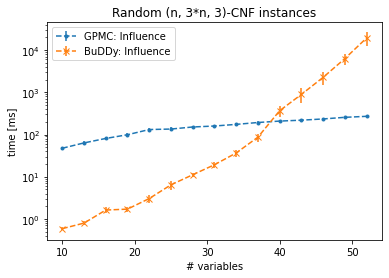

In [9]:
plot(means, stds, "GPMC_influence_ot", fmt=".--", label="GPMC: Influence")
plot(means, stds, "BDD_influence_ot", fmt="x--", label="BuDDy: Influence")
plt.show()

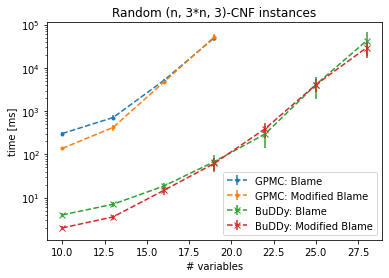

In [10]:
plot(means, stds, "GPMC_blame_ot", fmt=".--", label="GPMC: Blame")
plot(means, stds, "GPMC_mod_blame_ot", fmt=".--", label="GPMC: Modified Blame")
plot(means, stds, "BDD_blame_ot", fmt="x--", label="BuDDy: Blame")
plot(means, stds, "BDD_mod_blame_ot", fmt="x--", label="BuDDy: Modified Blame")
plt.show()

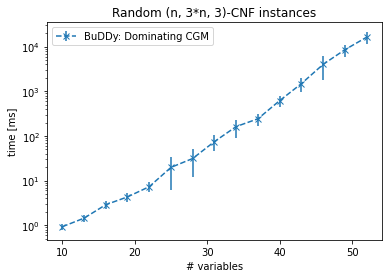

In [11]:
plot(means, stds, "BDD_dominating_cgm_ot", fmt="x--", label="BuDDy: Dominating CGM")